# Подгружаем конфиг

In [3]:
from src.schemas import TrainingConfig, InferenceSettings
from src.logger import setup_logger
import torch
from src.load import load_fantastic_dataset, load_drones_dataset
from transformers import CLIPTokenizer
from src.data_processor import DataPreprocessor
from src.model import CustomStableDiffusion
import json


%load_ext autoreload
%autoreload 2

device = "cuda" if torch.cuda.is_available() else "cpu"

# Читаем настройки из train_settings.json
with open("train_settings.json", "r") as f:
    config = json.load(f)

settings = TrainingConfig(**config, device=device)

# Инициализируем логер
logger = setup_logger(model_name=settings.model_name)
logger.info("Logger initialized.")

logger.info(f"Start with device: {settings.device}")

# # Загрузка датасета
# filename = "dataset/dataset.csv"
# path_to_images = "dataset/images"
# dataset = load_fantastic_dataset(filename=filename, path_to_images=path_to_images)
# logger.info("Fantastic dataset is loaded!")

image_folder = "drone-dataset/"
dataset = load_drones_dataset(image_folder=image_folder)
logger.info("Droneswoh dataset is loaded!")

settings.num_training_steps = settings.num_epochs * ( len(dataset) / settings.batch_size)
logger.info("***** Training configuration loaded: *****")
for key, value in config.items():
    logger.info(f"{key}: {value}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Препроцессинг текста и изображений:

In [4]:
tokenizer = CLIPTokenizer.from_pretrained(settings.model_name, subfolder="tokenizer")
data_processor = DataPreprocessor(tokenizer=tokenizer, logger=logger)

dataset = dataset.train_test_split(test_size=0.3, seed=42)

train_dataloader = data_processor.transform(
    dataset["train"],
    batch_size=settings.batch_size,
    num_workers=settings.num_workers,
    shuffle=settings.shuffle,
    max_tokenize_length=settings.max_tokenize_length,
    image_resize=settings.image_resize,
)

val_dataloader = data_processor.transform(
    dataset["test"],
    batch_size=settings.batch_size,
    num_workers=settings.num_workers,
    shuffle=settings.shuffle,
    max_tokenize_length=settings.max_tokenize_length,
    image_resize=settings.image_resize,
)

preprocess_images: 100%|██████████| 54/54 [00:01<00:00, 37.24 examples/s]


# Обучение:

In [5]:
model = CustomStableDiffusion(logger=logger)
model.init_model(settings)

In [ ]:
model.fit(train_dataloader=train_dataloader, val_dataloader=val_dataloader, settings=settings)

Epoch 1:   0%|          | 0/21 [00:00<?, ?it/s]/home/borinskikhsd/fine-tuning/venv/lib/python3.12/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
Epoch 1:  33%|███▎      | 7/21 [00:23<00:43,  3.13s/it]

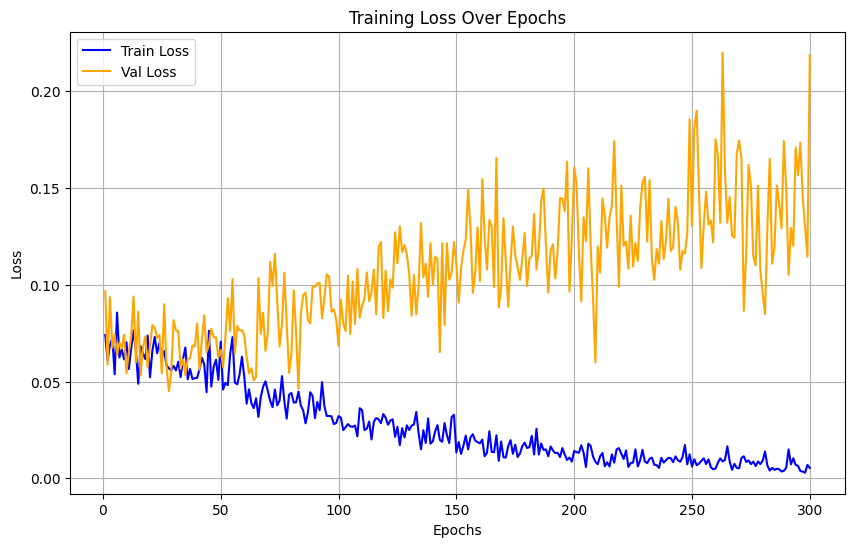

In [5]:
model.plot_loss()

# Сохраняем модельку

In [6]:
model.save_model(settings.model_name, is_save_to_disk=True, path_to_save='models/model_v1/')

Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00, 61.28it/s]


# Генерируем изображение

In [7]:
inference_settings = InferenceSettings(
    guidance_scale=7,
    num_inference_steps=100,
    height=512,
    width=512,
    generator=torch.manual_seed(42)
)

100%|██████████| 100/100 [00:10<00:00,  9.20it/s]


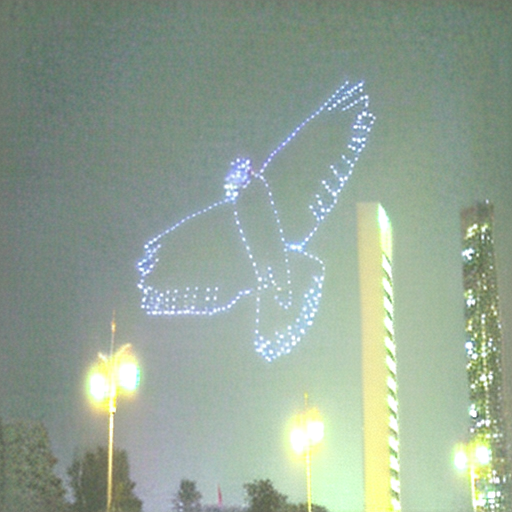

In [8]:
prompt = "drone lightshow of a bird with wings spread over skyscrapers and streetlights and trees"
target_height = 512
target_width = 512 
is_resize = True
model.inference(prompt, inference_settings,  target_height=target_height, target_width=target_width, is_resize=is_resize, device=settings.device)

  2%|▏         | 2/100 [00:00<00:14,  6.58it/s]

100%|██████████| 100/100 [00:10<00:00,  9.20it/s]


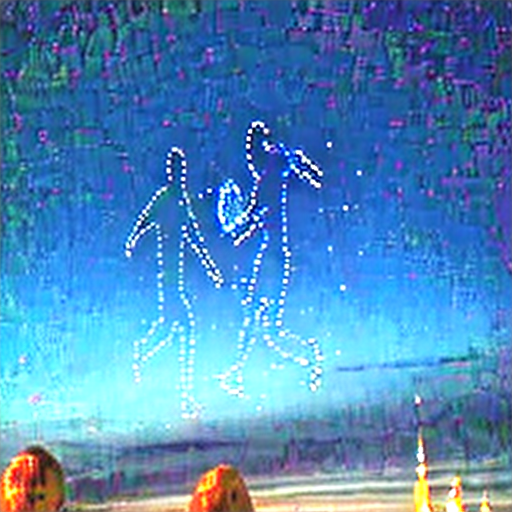

In [9]:
prompt = "drone lightshow of two white and blue men playing with a soccerball over a beach and tower spires on a starry night"
target_height = 512
target_width = 512 
is_resize = False
model.inference(prompt, inference_settings,  target_height=target_height, target_width=target_width, is_resize=is_resize, device=settings.device)

  2%|▏         | 2/100 [00:00<00:14,  6.61it/s]

100%|██████████| 100/100 [00:10<00:00,  9.18it/s]


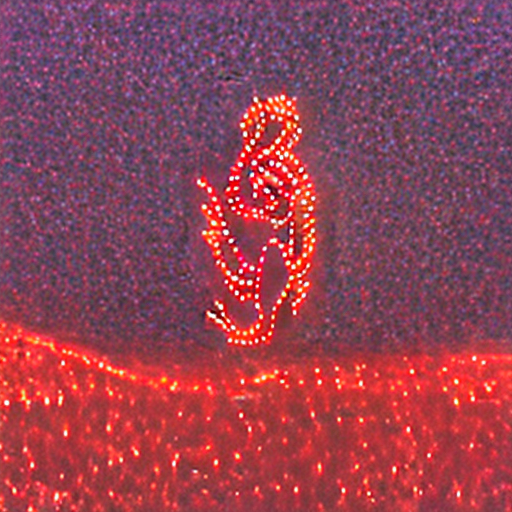

In [10]:
prompt = "drone lightshow of a massive red dragon spiraling through the sky above a misty mountain range"
target_height = 512
target_width = 512 
is_resize = True
model.inference(prompt, inference_settings,  target_height=target_height, target_width=target_width, is_resize=is_resize, device=settings.device)

  2%|▏         | 2/100 [00:00<00:14,  6.61it/s]

100%|██████████| 100/100 [00:10<00:00,  9.16it/s]


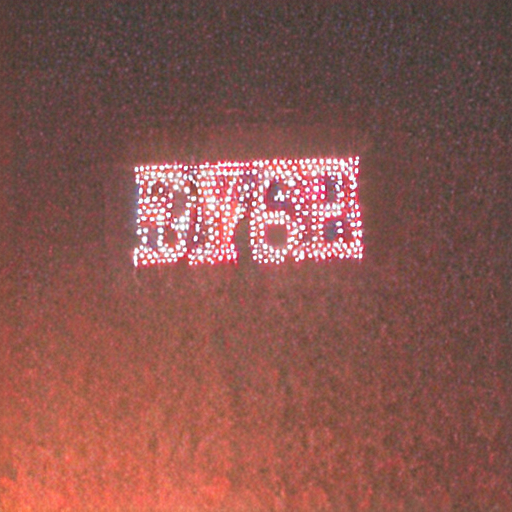

In [11]:
prompt = "drone lightshow spelling the word 'LOVE IS' during a romantic sunset"
target_height = 512
target_width = 512 
is_resize = True
model.inference(prompt, inference_settings,  target_height=target_height, target_width=target_width, is_resize=is_resize, device=settings.device)

In [12]:
# prompt = "a girl with long hair, dressed in an ornate dress"  # 21
# target_height = 290
# target_width = 106
# is_resize = True
# model.inference(prompt, inference_settings, target_height=target_height, target_width=target_width, is_resize=is_resize, device=settings.device)

In [13]:
# prompt = "a man holding a tray of chocolate"  # 85
# target_height = 252
# target_width = 96
# is_resize = True
# model.inference(prompt, inference_settings,  target_height=target_height, target_width=target_width, is_resize=is_resize, device=settings.device)

In [14]:
# prompt = "a person wearing a monkey outfit holding food"  # 39
# target_height = 283
# target_width = 141
# is_resize = True
# model.inference(prompt, inference_settings,  target_height=target_height, target_width=target_width, is_resize=is_resize, device=settings.device)

In [15]:
# prompt = "a demon with black sword"  # ?
# target_height = 283
# target_width = 141
# is_resize = True
# model.inference(prompt, inference_settings,  target_height=target_height, target_width=target_width, is_resize=is_resize, device=settings.device)

In [32]:
image_path = "drone-dataset/drone lightshow of the yellow and blue ikea logo made with 500 drones on a black background.jpg" 

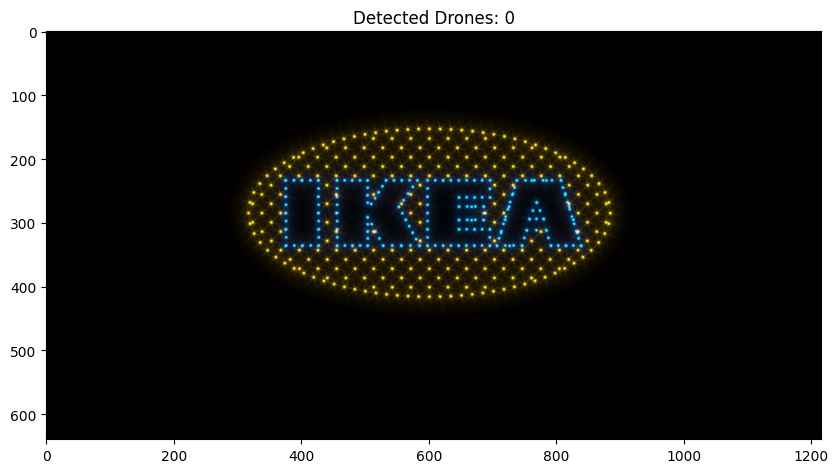

Количество обнаруженных дронов: 0
Пример координат дронов (первые 10 точек):
[]
Координаты сохранены в файл 'contrast_drone_coordinates.csv'


In [37]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Шаг 1: Загрузка изображения
image = cv2.imread(image_path, cv2.IMREAD_COLOR)

# Шаг 2: Увеличение контрастности с помощью CLAHE
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Применяем CLAHE (Contrast Limited Adaptive Histogram Equalization)
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
contrast_enhanced = clahe.apply(gray)

# Шаг 3: Удаление свечения с помощью размытия и вычитания фона
blurred = cv2.GaussianBlur(contrast_enhanced, (1, 1), 0)  # Размытие фона
enhanced = cv2.subtract(contrast_enhanced, blurred)  # Вычитаем фон

# Шаг 4: Бинаризация изображения
_, thresh = cv2.threshold(enhanced, 50, 255, cv2.THRESH_BINARY)

# Шаг 5: Настройка детектора точек
params = cv2.SimpleBlobDetector_Params()
params.filterByArea = True
params.minArea = 5  # Минимальная площадь точки
params.maxArea = 100
params.filterByCircularity = False
params.filterByConvexity = False
params.filterByInertia = False

detector = cv2.SimpleBlobDetector_create(params)
keypoints = detector.detect(thresh)

# Шаг 6: Получение координат точек
coordinates = [(int(k.pt[0]), int(k.pt[1])) for k in keypoints]

# Шаг 7: Визуализация
image_with_keypoints = cv2.drawKeypoints(
    image, keypoints, None, (0, 255, 255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image_with_keypoints, cv2.COLOR_BGR2RGB))
plt.title(f"Detected Drones: {len(coordinates)}")
plt.show()

# Шаг 8: Вывод результатов
print(f"Количество обнаруженных дронов: {len(coordinates)}")
print("Пример координат дронов (первые 10 точек):")
print(coordinates[:10])

# Сохранение координат в CSV
import pandas as pd
df = pd.DataFrame(coordinates, columns=["X", "Y"])
df.to_csv("contrast_drone_coordinates.csv", index=False)
print("Координаты сохранены в файл 'contrast_drone_coordinates.csv'")


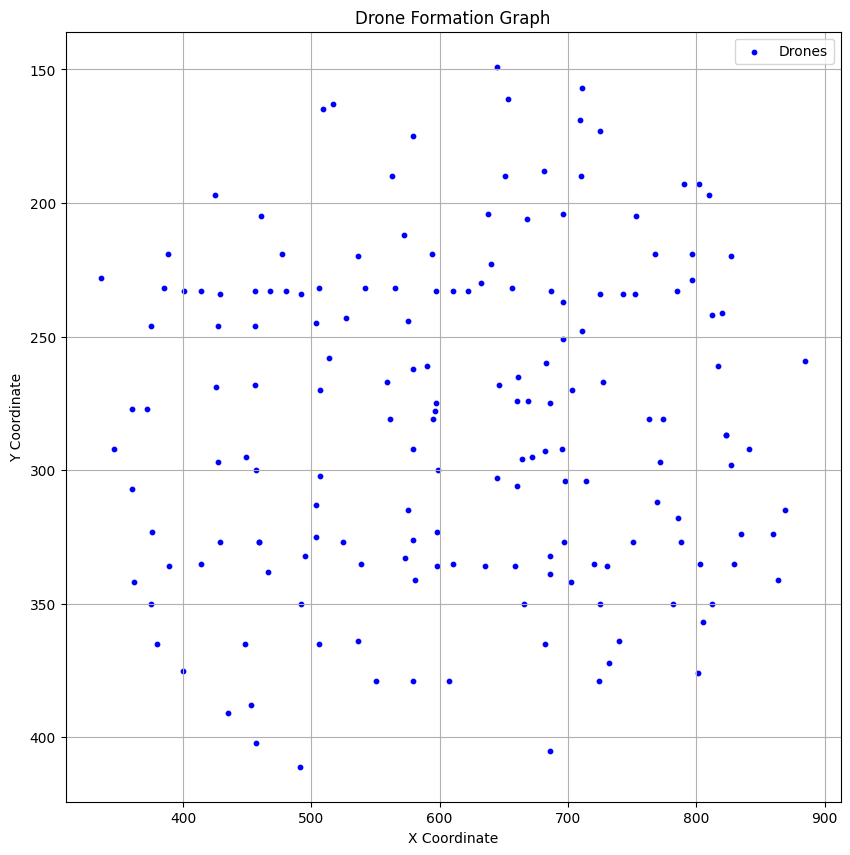

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# Шаг 1: Загрузка координат из файла
coordinates_file = "drone_coordinates.csv"  # Путь к CSV-файлу
df = pd.read_csv(coordinates_file)

# Шаг 2: Построение графика
plt.figure(figsize=(10, 10))
plt.scatter(df['X'], df['Y'], c='blue', s=10, label='Drones')
plt.title("Drone Formation Graph")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.gca().invert_yaxis()  # Инвертируем ось Y для корректного отображения
plt.legend()
plt.grid(True)
plt.show()
